In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env IGS_BRATS_T=1
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable
import pandas as pd
import seaborn as sns
import torch
from optimize_pattern import get_dataset, get_segmentation_model, PatternSampler, COIL_MAP
from optimize_pattern import dice_loss
from typing import Dict, List
import pylab as plt
# plt.style.use('fivethirtyeight')
plt.matplotlib.rcParams['axes.labelsize'] = 12
plt.matplotlib.rcParams['font.size'] = 12
plt.matplotlib.rcParams['axes.titlesize'] = 12

def fake_batch(data: Dict[str, torch.tensor]):
    return {k:v[None] for k,v in data.items()}

def dice_3d_brats_vec(gt: torch.tensor, pmask: torch.tensor, eps=1e-7):
    dice_ls = []
    # WT
    true_1_hot = ((gt == 1) | (gt == 2) | (gt == 3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==2) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)))
    # TC
    true_1_hot = ((gt == 1) | (gt == 3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)))
    # ET
    true_1_hot = ((gt == 1)).float().flatten()
    pred_1_hot = ((pmask==1)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)))
    return dice_ls

def dice_3d_acdc_vec(gt: torch.tensor, pmask: torch.tensor, eps=1e-7):
    dice_ls = []
    # 1
    true_1_hot = (gt == 1).float().flatten()
    pred_1_hot = (pmask==1).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)))
    # 2
    true_1_hot = (gt == 2).float().flatten()
    pred_1_hot = (pmask==2).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)))
    # 3
    true_1_hot = (gt == 3).float().flatten()
    pred_1_hot = (pmask==3).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)))
    return dice_ls

env: CUDA_VISIBLE_DEVICES=0
env: IGS_BRATS_T=1


# Unet3D 2d pattern

In [2]:
%env IGS_BRATS_T=1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_, val_dataset = get_dataset(name='brats', volumetric=True, device=device)
S = get_segmentation_model(
    dataset_name='brats',
    name='unet3d',
    f_path='models/brats_singlecoil_unet3dc24.pt',
    nchans=24, nlayers=4, device=device
)
k_sampler = PatternSampler(f_maps=None, shape=[240, 240], device=device)
patterns = dict(
    Center = torch.load('/home/a_razumov/projects/igs/patterns/center_2d_240.pt'),
    Ours = torch.load('logs/pattern/brats/unet3d/igs/x64_singlecoil_2d_dice/v1/pattern.pt'),
    LOUPE = torch.load('logs/pattern/brats/unet3d/loupe/x64_singlecoil_2d_dice/v1/pattern.pt'),
    Full = torch.ones_like(torch.load('patterns/center_2d_240.pt'))
)

env: IGS_BRATS_T=1


In [3]:
gt_data = fake_batch(val_dataset[0])
datas = {k:k_sampler(gt_data, sampling=v) for k,v in patterns.items()}
with torch.no_grad():
    masks = {k:S(data['img']).argmax(1).cpu().detach() for k,data in datas.items()}

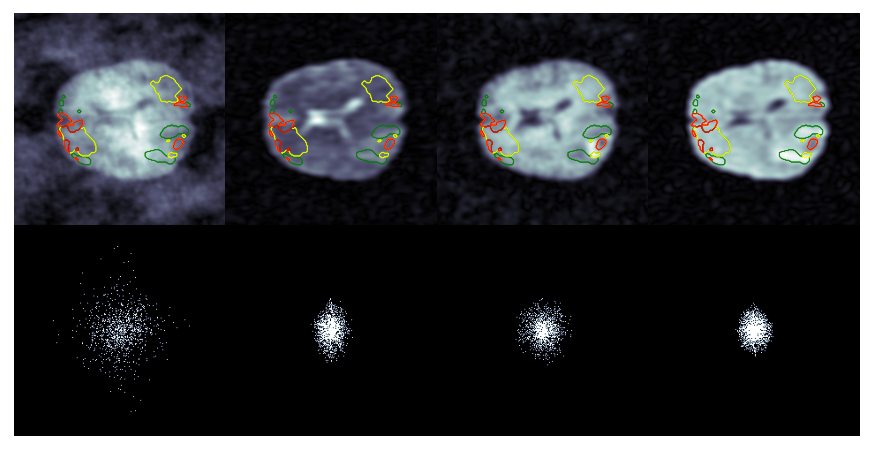

In [4]:
method = 'LOUPE'
slice = 80

fig = plt.figure(figsize=(8, 4), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,4), axes_pad=0.0)
cc = 0
for ax, im in zip(grid, [
    *(datas[method]['img'] * datas[method]['std'] + datas[method]['mean'])[0,:,slice].cpu().detach(),
    *patterns[method]
]):
    if im.shape[0] == 1:
        im = im.repeat(im.shape[-1],1)
    ax.imshow(im.abs(), cmap=plt.cm.bone)
    if cc < 4:
        mm = ((masks[method][0, slice] == 1) | (masks[method][0, slice] == 2) | (masks[method][0, slice]) == 3).float()
        ax.contour(mm, colors=['green'], linewidths=0.15)
        mm = ((masks[method][0, slice] == 1) | (masks[method][0, slice] == 3)).float()
        ax.contour(mm, colors=['yellow'], linewidths=0.15)
        mm = ((masks[method][0, slice] == 1)).float()
        ax.contour(mm, colors=['red'], linewidths=0.15)
        # ax.imshow(masks[method][0,slice], cmap=plt.cm.jet, alpha=0.5)
    ax.axis('off')
    cc += 1
plt.show()

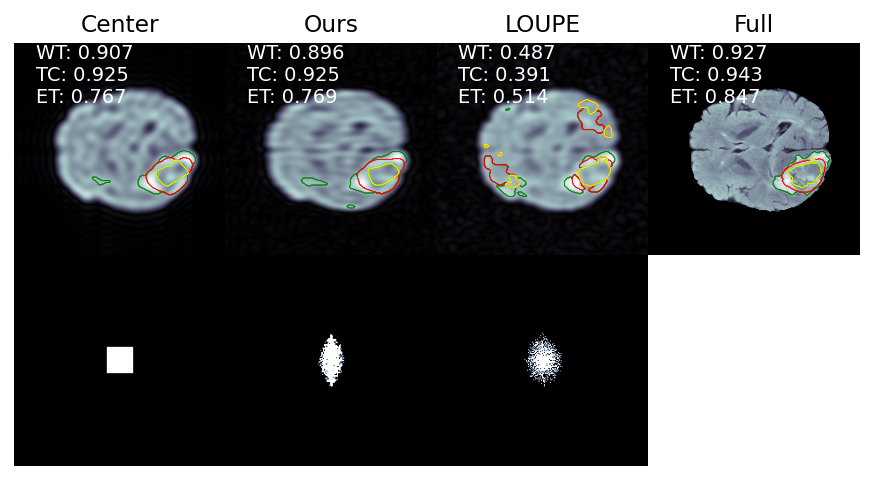

In [5]:
channel = 3
slice = 70

fig = plt.figure(figsize=(8, 4), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,len(patterns.keys())), axes_pad=0.0)
cc = 0
methods = list(patterns.keys())
for ax, im, method in zip(grid, [
    *[(datas[m]['img'] * datas[m]['std'] + datas[m]['mean'])[0,channel,slice].cpu().detach()
      for m in methods],
    *[patterns[m][channel] for m in methods]
], [*methods, *methods]):
    if im.shape[0] == 1:
        im = im.repeat(50,1)
    if im.mean() == 1:
        ax.imshow(im.abs(), cmap=plt.cm.bone_r)
    else:
        ax.imshow(im.abs(), cmap=plt.cm.bone)
    if cc < len(patterns.keys()):
        ax.set_title(f'{method}')
        mm = ((masks[method][0, slice] == 1) | (masks[method][0, slice] == 2) | (masks[method][0, slice]) == 3).float()
        ax.contour(mm, colors=['green'], linewidths=0.15)
        mm = ((masks[method][0, slice] == 1) | (masks[method][0, slice] == 3)).float()
        ax.contour(mm, colors=['red'], linewidths=0.15)
        mm = ((masks[method][0, slice] == 1)).float()
        ax.contour(mm, colors=['yellow'], linewidths=0.15)
        scores = dice_3d_brats_vec(
            gt_data['mask'].movedim(1,2).flatten(0, 1).cpu().detach(),
            masks[method][None].movedim(1,2).flatten(0, 1)
        )
        scores = [round(v.item(), 3) for v in scores]
        ax.text(24, 67, f'WT: {scores[0]}\nTC: {scores[1]}\nET: {scores[2]}',
                c='w', fontsize=10)
        # ax.imshow(masks[method][0,slice], cmap=plt.cm.jet, alpha=0.5)
    ax.axis('off')
    cc += 1
plt.savefig('/tmp/plot.eps', bbox_inches = "tight")
plt.show()

# Unet 1d pattern

In [60]:
%env IGS_BRATS_T=0
%env IGS_BRATS_RT=1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_, val_dataset = get_dataset(name='brats', volumetric=True, device=device)
S = dict(
    Equispaced = get_segmentation_model(
        dataset_name='brats',
        name='unet',
        f_path='logs/legacy/brats/model_fastmri.pt',
        nchans=32, nlayers=4, device=device
    ),
    Center = get_segmentation_model(
        dataset_name='brats',
        name='unet',
        f_path='logs/legacy/brats/model_zm.pt',
        nchans=32, nlayers=4, device=device
    ),
    Ours = get_segmentation_model(
        dataset_name='brats',
        name='unet',
        f_path='logs/legacy/brats/model_igs.pt',
        nchans=32, nlayers=4, device=device
    ),
    LOUPE = get_segmentation_model(
        dataset_name='brats',
        name='unet',
        f_path='logs/pattern/brats/unet/loupe/x15_singlecoil_1d_dice/v2/model_state.pt',
        nchans=32, nlayers=4, device=device
    ),
    Full = get_segmentation_model(
        dataset_name='brats',
        name='unet',
        f_path='models/brats_singlecoil_c32.pt',
        nchans=32, nlayers=4, device=device
    ),
)


k_sampler = PatternSampler(f_maps=None, shape=[240, 240], device=device)
patterns = dict(
    Equispaced = torch.load('patterns/equispaced_1d_240.pt'),
    Center = torch.load('patterns/center_1d_240.pt'),
    Ours = torch.load('logs/legacy/brats/sampling_igs_finetune.pt')[:, None],
    LOUPE = torch.load('logs/pattern/brats/unet/loupe/x15_singlecoil_1d_dice/v2/pattern.pt'),
    Full = torch.ones_like(torch.load('patterns/center_1d_240.pt'))
)

env: IGS_BRATS_T=0
env: IGS_BRATS_RT=1


In [61]:
val_dataset.indexes.index('69')

77

In [62]:
_gt_data = fake_batch(val_dataset[77])
gt_data = k_sampler(_gt_data)
datas = {k:k_sampler(_gt_data, sampling=v) for k,v in patterns.items()}
with torch.no_grad():
    masks = {k:S[k](data['img'].flatten(0, 1).movedim(0,1)).softmax(1).argmax(1)[None].cpu().detach() for k,data in datas.items()}

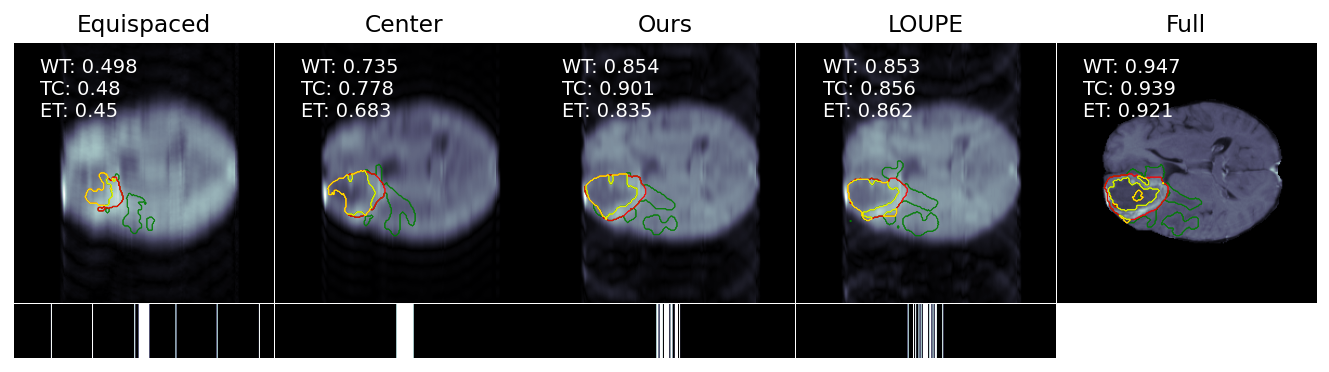

In [63]:
channel = 2
slice = 80

fig = plt.figure(figsize=(12, 8), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,len(patterns.keys())), axes_pad=0.01)
cc = 0
methods = list(patterns.keys())
for ax, im, method in zip(grid, [
    *[(datas[m]['img'] * datas[m]['std'] + datas[m]['mean'])[0,channel,slice].cpu().detach() for m in methods],
    *[patterns[m][channel].cpu().detach() for m in methods]
], [*methods, *methods]):
    if im.shape[0] == 1:
        im = im.repeat(50,1)
    if im.mean() == 1:
        ax.imshow(im.abs(), cmap=plt.cm.bone_r)
    else:
        ax.imshow(im.abs(), cmap=plt.cm.bone)
    if cc < len(patterns.keys()):
        ax.set_title(f'{method}')
        mm = ((masks[method][0, slice] == 1) | (masks[method][0, slice] == 2) | (masks[method][0, slice]) == 3).float()
        ax.contour(mm, colors=['green'], linewidths=0.15)
        mm = ((masks[method][0, slice] == 1) | (masks[method][0, slice] == 3)).float()
        ax.contour(mm, colors=['red'], linewidths=0.15)
        mm = ((masks[method][0, slice] == 1)).float()
        ax.contour(mm, colors=['yellow'], linewidths=0.15)
        # ax.imshow(masks[method][0,slice], cmap=plt.cm.jet, alpha=0.5)
        scores = dice_3d_brats_vec(
            gt_data['mask'].movedim(1,2).flatten(0, 1)[slice][None].cpu().detach(),
            masks[method][0][:,None][slice][None]
        )
        scores = [round(v.item(), 3) for v in scores]
        ax.text(24, 67, f'WT: {scores[0]}\nTC: {scores[1]}\nET: {scores[2]}',
                c='w', fontsize=10)
    ax.axis('off')
    cc += 1
plt.savefig('/tmp/plot1.eps', bbox_inches = "tight")
plt.show()

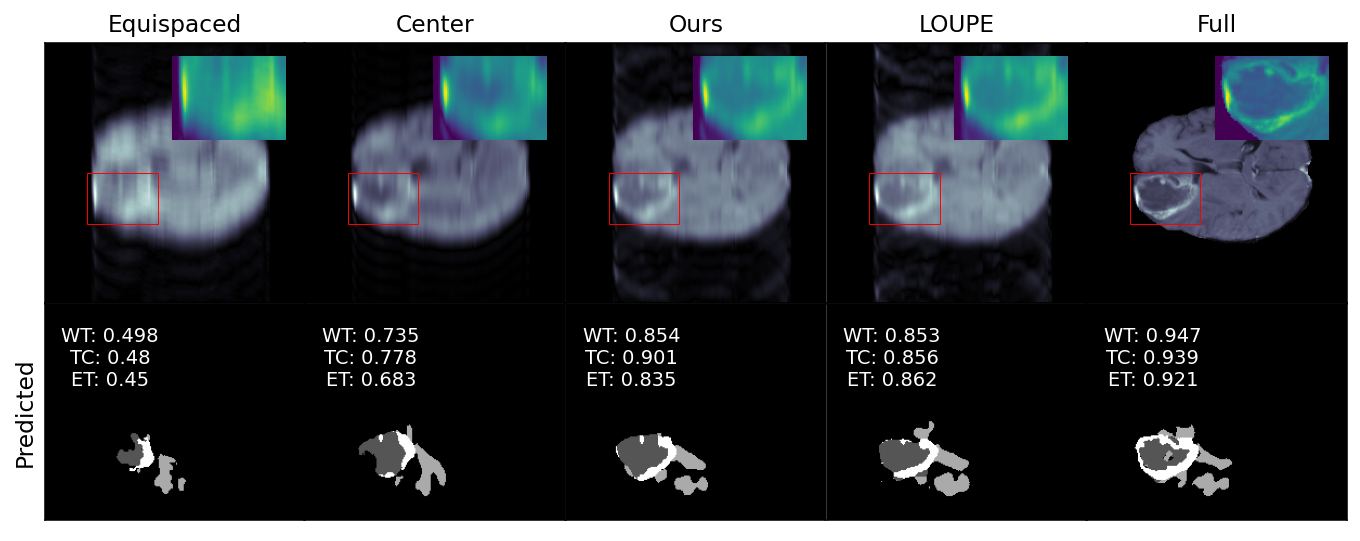

In [64]:
channel = 2
slice = 80

fig = plt.figure(figsize=(12, 8), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,len(patterns.keys())), axes_pad=0.01)
cc = 0
methods = list(patterns.keys())
for ax, im, method in zip(grid, [
    *[(datas[m]['img'] * datas[m]['std'] + datas[m]['mean'])[0,channel,slice].cpu().detach() for m in methods],
    *[patterns[m][channel].cpu().detach() for m in methods]
], [*methods, *methods]):
    if cc < len(patterns.keys()):
        ax.set_title(f'{method}')
        ax.imshow(im.abs(), cmap=plt.cm.bone)
        im = plt.matplotlib.offsetbox.OffsetImage(ax.images[0].get_array().data[119:167,39:104], zoom=0.9)
        rect = plt.matplotlib.patches.Rectangle((39, 119), 104-39, 167-119, linewidth=0.5, edgecolor='r', facecolor='none')
        im.image.axes = ax
        ab = plt.matplotlib.offsetbox.AnnotationBbox(
            im, (0, 0),
            xybox=(170., 50.),
            pad=0.2,
            frameon=False,
        )
        ax.add_artist(ab)
        ax.add_patch(rect)
    elif cc >= len(patterns.keys()):
        ax.imshow(masks[method][0,slice][:200], cmap=plt.cm.gray)
        scores = dice_3d_brats_vec(
            gt_data['mask'].movedim(1,2).flatten(0, 1)[slice][None].cpu().detach(),
            masks[method][0][:,None][slice][None]
        )
        scores = [round(v.item(), 3) for v in scores]
        ax.text(60, 50, f'WT: {scores[0]}\nTC: {scores[1]}\nET: {scores[2]}', c='w', fontsize=10, ha='center', va='center')
        if cc == len(patterns.keys()):
            ax.set_ylabel('Predicted')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    cc += 1
plt.savefig('/tmp/plot.eps', bbox_inches = "tight")
plt.show()

# ACDC Unet

In [2]:
%env IGS_BRATS_T=0
%env IGS_BRATS_RT=0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_, val_dataset = get_dataset(name='acdc', volumetric=False, device=device)
S = dict(
    Equispaced = get_segmentation_model(
        dataset_name='acdc',
        name='unet',
        f_path='logs/model_fastmri.pt',
        nchans=32, nlayers=4, device=device
    ).eval(),
    Center = get_segmentation_model(
        dataset_name='acdc',
        name='unet',
        f_path='models/center1d/acdc_multicoil_c32.pt',
        nchans=32, nlayers=4, device=device
    ).eval(),
    Ours = get_segmentation_model(
        dataset_name='acdc',
        name='unet',
        f_path='models/igs1d/acdc_multicoil_c32.pt',
        nchans=32, nlayers=4, device=device
    ).eval(),
    LOUPE = get_segmentation_model(
        dataset_name='acdc',
        name='unet',
        f_path='logs/pattern/acdc/unet/loupe/x16_multicoil_1d_dice/v1/model_state.pt',
        nchans=32, nlayers=4, device=device
    ).eval(),
    Full = get_segmentation_model(
        dataset_name='acdc',
        name='unet',
        f_path='models/acdc_singlecoil_c32.pt',
        nchans=32, nlayers=4, device=device
    ).eval(),
)
k_sampler = PatternSampler(f_maps=None, shape=[256, 256], device=device)
patterns = dict(
    Equispaced = torch.load('patterns/equispaced_1d_256.pt').float(),
    Center = torch.load('patterns/center_1d_256.pt').float(),
    # Ours = torch.load('logs/pattern/acdc/unet/igs/x16_multicoil_1d_dice/v1/pattern.pt'),
    Ours = torch.load('/home/a_razumov/projects/igs/logs/sampling_igs_finetune.pt')[None],
    LOUPE = torch.load('logs/pattern/acdc/unet/loupe/x16_multicoil_1d_dice/v1/pattern.pt'),
    Full = torch.ones_like(torch.load('patterns/center_1d_256.pt'))
)

env: IGS_BRATS_T=0
env: IGS_BRATS_RT=0


In [3]:
_gt_data = fake_batch(val_dataset[395])
gt_data = k_sampler(_gt_data)
datas = {k:k_sampler(_gt_data, sampling=v) for k,v in patterns.items()}
with torch.no_grad():
    masks = {k:S[k](data['img']).argmax(1)[None].cpu().detach() for k,data in datas.items()}

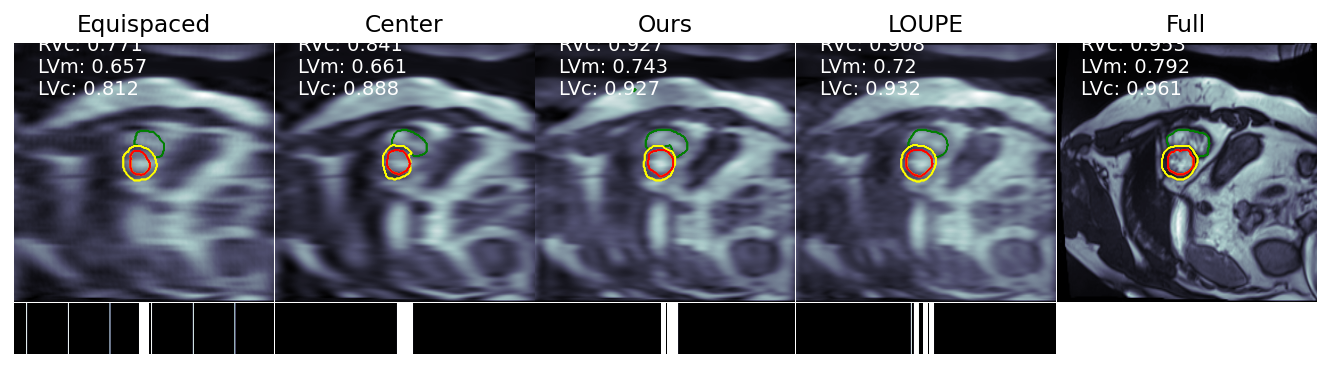

In [4]:
channel = 0
slice = 0

fig = plt.figure(figsize=(12, 6), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,len(patterns.keys())), axes_pad=0.01)
cc = 0
methods = list(patterns.keys())
for ax, im, method in zip(grid, [
    *[(datas[m]['img'] * datas[m]['std'] + datas[m]['mean'])[channel,slice].cpu().detach() for m in methods],
    *[patterns[m].cpu().detach() for m in methods]
], [*methods, *methods]):
    if im.shape[0] == 1:
        im = im.repeat(50,1)
    if im.mean() == 1:
        ax.imshow(im.abs(), cmap=plt.cm.bone_r)
    else:
        ax.imshow(im.abs(), cmap=plt.cm.bone)
    if cc < len(patterns.keys()):
        ax.set_title(f'{method}')
        mm = ((masks[method][0, slice] == 1)).float()
        ax.contour(mm, colors=['green'], linewidths=0.5)
        mm = ((masks[method][0, slice] == 2)).float()
        ax.contour(mm, colors=['yellow'], linewidths=0.5)
        mm = ((masks[method][0, slice] == 3)).float()
        ax.contour(mm, colors=['red'], linewidths=0.5)
        # ax.imshow(masks[method][0,slice], cmap=plt.cm.jet, alpha=0.2)
        scores = dice_3d_acdc_vec(
            gt_data['mask'][slice][None].cpu().detach(),
            masks[method][0][:,None][slice][None]
        )
        scores = [round(v.item(), 3) for v in scores]
        ax.text(23, 50, f'RVc: {scores[0]}\nLVm: {scores[1]}\nLVc: {scores[2]}', c='w', fontsize=10)
    ax.axis('off')
    cc += 1
plt.show()

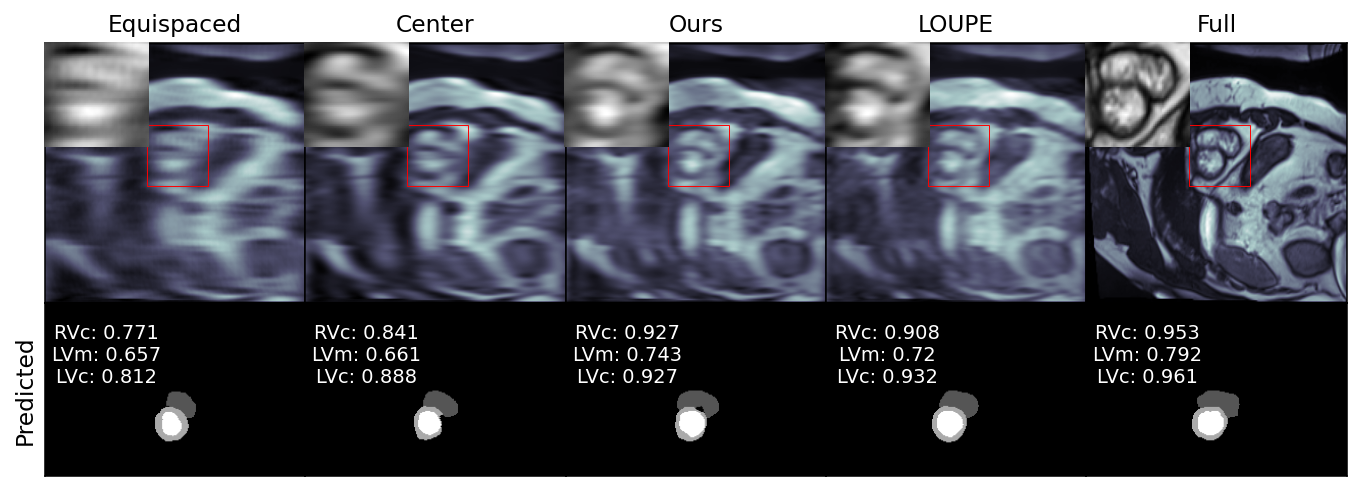

In [7]:
channel = 0
slice = 0

fig = plt.figure(figsize=(12, 9), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,len(patterns.keys())), axes_pad=0.0)
cc = 0
methods = list(patterns.keys())
for ax, im, method in zip(grid, [
    *[(datas[m]['img'] * datas[m]['std'] + datas[m]['mean'])[channel,slice].cpu().detach() for m in methods],
    *[patterns[m].cpu().detach() for m in methods]
], [*methods, *methods]):
    if cc < len(patterns.keys()):
        ax.set_title(f'{method}')
        ax.imshow(im.abs(), cmap=plt.cm.bone)
        im = plt.matplotlib.offsetbox.OffsetImage(ax.images[0].get_array().data[80:80+60,100:100+60], cmap=plt.cm.gray, zoom=0.9)
        rect = plt.matplotlib.patches.Rectangle((100, 80), 60, 60, linewidth=0.5, edgecolor='r', facecolor='none')
        im.image.axes = ax
        ab = plt.matplotlib.offsetbox.AnnotationBbox(
            im, (0, 0),
            xybox=(50., 50.),
            pad=0.2,
            frameon=False,
        )
        ax.add_artist(ab)
        ax.add_patch(rect)
    elif cc >= len(patterns.keys()):
        ax.imshow(masks[method][0,slice][:170], cmap=plt.cm.gray)
        scores = dice_3d_acdc_vec(
            gt_data['mask'][slice][None].cpu().detach(),
            masks[method][0][:,None][slice][None]
        )
        scores = [round(v.item(), 3) for v in scores]
        ax.text(60, 50, f'RVc: {scores[0]}\nLVm: {scores[1]}\nLVc: {scores[2]}', c='w', fontsize=10, ha='center', va='center')
        if cc == len(patterns.keys()):
            ax.set_ylabel('Predicted')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    cc += 1
plt.savefig('/tmp/plot.eps', bbox_inches = "tight")
plt.show()

# BraTS Reconstruction

In [100]:
%env IGS_BRATS_T=0
%env IGS_BRATS_RT=1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_, val_dataset = get_dataset(name='brats', volumetric=True, device=device)
k_sampler = PatternSampler(f_maps=None, shape=[240, 240], device=device)
patterns = dict(
    Equispaced = torch.load('patterns/equispaced_1d_240.pt'),
    Center = torch.load('patterns/center_1d_240.pt'),
    Ours = torch.load('logs/legacy/brats-zf-recon/sampling_igs.pt')[:, None],
    LOUPE = torch.load('logs/pattern/brats/none/loupe/x16_singlecoil_1d_ssim/v1/pattern.pt'),
    Full = torch.ones_like(torch.load('patterns/center_1d_240.pt'))
)

env: IGS_BRATS_T=0
env: IGS_BRATS_RT=1


In [104]:
_gt_data = fake_batch(val_dataset[0])
gt_data = k_sampler(_gt_data)
datas = {k:k_sampler(_gt_data, sampling=v) for k,v in patterns.items()}

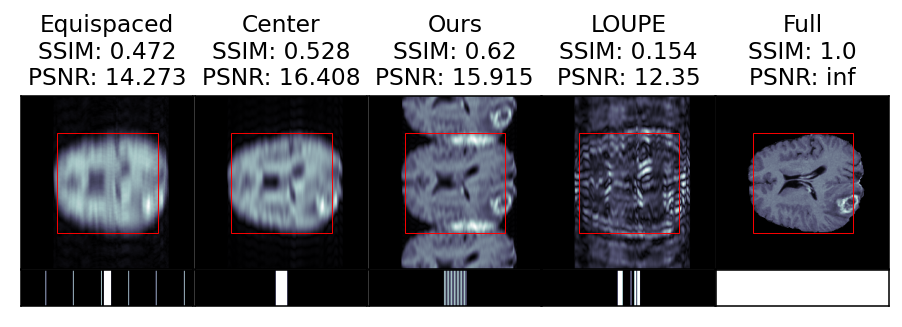

In [113]:
from optimize_pattern import pt_ssim, t2i

def pt_psnr(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    maxval = gt.max()
    mse = torch.mean((pred - gt) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

channel = 2
slice = 80
gt = (datas['Full']['img'] * datas['Full']['std'] + datas['Full']['mean'])[0,channel,slice].cpu().detach()
fig = plt.figure(figsize=(4*2,16*2), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,len(patterns.keys())), axes_pad=0.01)
cc = 0
methods = list(patterns.keys())
for ax, im, method in zip(grid, [
    *[(datas[m]['img'] * datas[m]['std'] + datas[m]['mean'])[0,channel,slice].cpu().detach() for m in methods],
    *[patterns[m][channel].cpu().detach() for m in methods]
], [*methods, *methods]):
    if cc < len(patterns.keys()):
        ssim_val = pt_ssim(im[50:-50, 50:-50][None,None], gt[50:-50, 50:-50][None,None]).item()
        psnr_val = pt_psnr(im[50:-50, 50:-50][None,None], gt[50:-50, 50:-50][None,None]).item()
        ax.set_title(f'{method}\nSSIM: {round(ssim_val, 3)}\nPSNR: {round(psnr_val, 3)}')
        ax.add_patch(plt.matplotlib.patches.Rectangle((50, 50), 140, 140, linewidth=0.5, edgecolor='r', facecolor='none'))
    if im.shape[0] == 1:
        im = im.repeat(50,1)
    if im.mean() == 1:
        ax.imshow(im.abs(), cmap=plt.cm.bone_r)
    else:
        ax.imshow(im.abs(), cmap=plt.cm.bone)
    # if cc == len(patterns.keys()):
    #     ax.set_ylabel('Predicted')
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    cc += 1
plt.savefig('/tmp/plot1.eps', bbox_inches = "tight")
plt.show()

In [88]:
%env IGS_BRATS_T=0
%env IGS_BRATS_RT=1
from kspace import EquispacedMaskFunc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_, val_dataset = get_dataset(name='fastmri', volumetric=True, device=device)
k_sampler = PatternSampler(f_maps=None, shape=[320, 320], device=device)
zm = torch.zeros(1, 320)
zm[:, 320 // 2 - (320 // 4) // 2: 320 // 2 + 320 // 4 - (320 // 4) // 2] = 1
patterns = dict(
    Equispaced = torch.tensor(EquispacedMaskFunc([0.02], [4])((320, 320))[0])[None],
    Center = zm,
    Ours = torch.load('logs/legacy/fastmri-knee-zf-recon/sampling_igs.pt')[-1][None],
    LOUPE = torch.load('logs/pattern/fastmri/none/loupe/x4_singlecoil_1d_l1/v2/pattern.pt'),
    Full = torch.ones_like(zm)
)
print([patterns[k].shape for k in patterns])
print([patterns[k].norm(p=0) for k in patterns])

env: IGS_BRATS_T=0
env: IGS_BRATS_RT=1
[torch.Size([1, 320]), torch.Size([1, 320]), torch.Size([1, 320]), torch.Size([1, 320]), torch.Size([1, 320])]
[tensor(80.), tensor(80.), tensor(80., device='cuda:0'), tensor(80.), tensor(320.)]


In [89]:
_gt_data = fake_batch(val_dataset[0])
gt_data = k_sampler(_gt_data)
datas = {k:k_sampler(_gt_data, sampling=v) for k,v in patterns.items()}

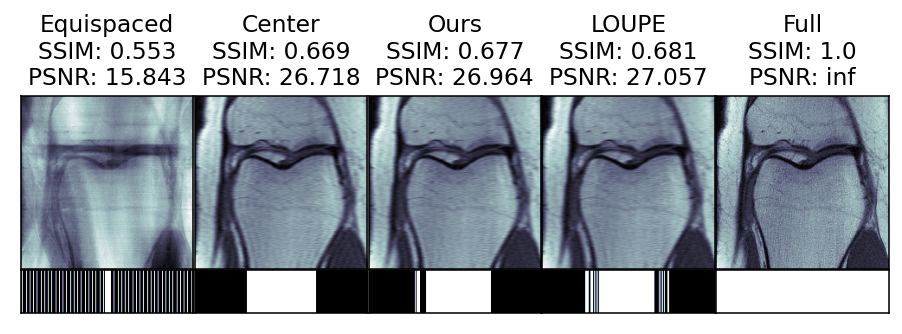

In [96]:
from optimize_pattern import pt_ssim2, t2i

def pt_psnr(pred, gt):
    pred = t2i(pred)
    gt = t2i(gt)
    maxval = gt.max()
    mse = torch.mean((pred - gt) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

channel = 0
slice = 15

fig = plt.figure(figsize=(4*2,16*2), dpi=140)
grid = ImageGrid(fig, 111, nrows_ncols=(2,len(patterns.keys())), axes_pad=0.01)
cc = 0
gt = (datas['Full']['img'] * datas['Full']['std'] + datas['Full']['mean'])[0,channel,slice].cpu().detach().T
methods = list(patterns.keys())
for ax, im, method in zip(grid, [
    *[(datas[m]['img'] * datas[m]['std'] + datas[m]['mean'])[0,channel,slice].cpu().detach().T for m in methods],
    *[patterns[m].cpu().detach() for m in methods]
], [*methods, *methods]):
    if cc < len(patterns.keys()):
        ssim_val = pt_ssim2(im[220:-220, 60:-60][None,None], gt[220:-220, 60:-60][None,None], val_range=gt[220:-220, 60:-60][None,None].max()).item()
        psnr_val = pt_psnr(im[220:-220, 60:-60][None,None], gt[220:-220, 60:-60][None,None]).item()
        ax.set_title(f'{method}\nSSIM: {round(ssim_val, 3)}\nPSNR: {round(psnr_val, 3)}')
    if im.shape[0] == 1:
        im = im.repeat(50,1)[:, 60:-60]
    elif im.shape[0] != im.shape[1]:
        im = im[220:-220, 60:-60]
    if im.mean() == 1:
        ax.imshow(im.abs(), cmap=plt.cm.bone_r)
    else:
        ax.imshow(im.abs(), cmap=plt.cm.bone)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    cc += 1
plt.savefig('/tmp/plot.eps', bbox_inches = "tight")
plt.show()